In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np
from PIL import Image
import os
keras = tf.keras
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D, Flatten
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import Model

2023-10-18 11:12:18.952605: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-18 11:12:19.104980: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 11:12:19.777619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Q1) Preprocessing

In [2]:
images = []

for i in os.listdir('images'):
    with Image.open(f'images/{i}') as img:
        img = img.resize((150, 150))
        images.append(np.asarray(img))

images[0:5]

[array([[[253, 186, 115],
         [253, 186, 115],
         [251, 184, 113],
         ...,
         [  9,   4,   1],
         [  6,   2,   0],
         [  7,   3,   2]],
 
        [[254, 187, 116],
         [253, 186, 115],
         [253, 186, 115],
         ...,
         [ 14,   9,   6],
         [  6,   1,   0],
         [  4,   1,   1]],
 
        [[254, 187, 116],
         [254, 187, 116],
         [253, 186, 115],
         ...,
         [ 19,  14,  10],
         [  8,   3,   2],
         [  5,   1,   0]],
 
        ...,
 
        [[154,  90,  55],
         [137,  73,  38],
         [136,  67,  34],
         ...,
         [ 88,  45,  33],
         [ 83,  37,  27],
         [ 89,  42,  32]],
 
        [[144,  79,  46],
         [135,  68,  35],
         [136,  66,  34],
         ...,
         [ 91,  46,  35],
         [ 81,  34,  24],
         [ 83,  36,  26]],
 
        [[136,  70,  38],
         [131,  64,  32],
         [142,  71,  41],
         ...,
         [ 93,  46,  36],
  

In [3]:
images = np.array(images)

In [4]:
images = images / 255.0

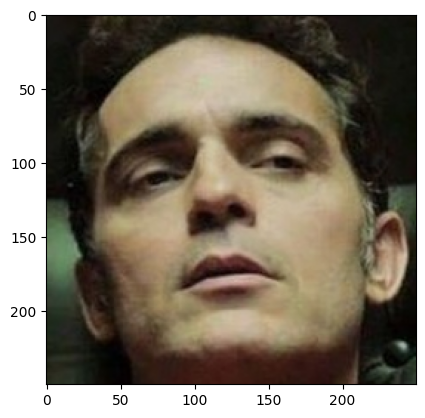

In [5]:
plt.imshow(images[150])

In [6]:
images.shape

(17534, 250, 250, 3)

In [7]:
X_train, X_val = train_test_split(images, test_size=0.2)
X_train.shape

(14027, 250, 250, 3)

In [8]:
X_val.shape

(3507, 250, 250, 3)

In [9]:
FLATTEN = 150 * 150 * 3

## Q2) Training reconstruction model

In [10]:
X_train = X_train.reshape((14027, FLATTEN))
X_val = X_val.reshape((3507, FLATTEN))

In [11]:
input_layer = Input(shape=(FLATTEN,))
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

latent_view   = Dense(100, activation='sigmoid')(encode_layer3)

decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

output_layer  = Dense(FLATTEN)(decode_layer3)

model = Model(input_layer, output_layer)

2023-10-18 11:14:12.742172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 11:14:12.952549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 11:14:12.952934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187500)]          0         
                                                                 
 dense (Dense)               (None, 1500)              281251500 
                                                                 
 dense_1 (Dense)             (None, 1000)              1501000   
                                                                 
 dense_2 (Dense)             (None, 500)               500500    
                                                                 
 dense_3 (Dense)             (None, 100)               50100     
                                                                 
 dense_4 (Dense)             (None, 500)               50500     
                                                                 
 dense_5 (Dense)             (None, 1000)              501000

In [13]:
model.compile(optimizer="adam", loss="mse")

In [14]:
model.fit(X_train, X_train, epochs=200, batch_size=32, validation_data=(X_val, X_val))

2023-10-18 11:15:52.063055: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.80GiB (rounded to 10520250112)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-10-18 11:15:52.064782: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-10-18 11:15:52.065583: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 14, Chunks in use: 14. 3.5KiB allocated for chunks. 3.5KiB in use in bin. 64B client-requested in use in bin.
2023-10-18 11:15:52.065602: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 400B client-requested in use in bin.
2023-10-18 11:15:52.065767: I tensorflow/tsl/framework/bfc_alloca

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
preds = model.predict(X_val)
preds[:10]

In [ ]:
plt.imshow(preds[50].reshape((100, 100, 3)))